In [1]:
import numpy as np
import tensorflow as tf 

In [2]:
from util import load_synthesized_data, build_dataset

df_train, df_val = load_synthesized_data(split=1000)

y_train = df_train['y'].values
y_val = df_val['y'].values
print("y_train.shape = {}, y_val.shape = {}".format(y_train.shape, y_val.shape))

y_train.shape = (1000,), y_val.shape = (461,)


In [3]:
WINDOW_SIZE = 20
BATCH_SIZE = 32
SHUFFER_BUFFER_SIZE = 1000
LEARNING_RATE = 1e-6
NUM_EPOCH = 100

In [4]:
from tensorflow.data import Dataset

dataset_train = Dataset.from_tensor_slices(y_train) \
    .window(WINDOW_SIZE + 1, shift=1, drop_remainder=True) \
    .flat_map(lambda window: window.batch(WINDOW_SIZE + 1)) \
    .shuffle(SHUFFER_BUFFER_SIZE).map(lambda window: (window[:-1], window[-1])) \
    .batch(BATCH_SIZE).prefetch(1)

In [5]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
 
model = Sequential([
    Dense(1, input_shape=[WINDOW_SIZE])
])

model.compile(loss='mse', optimizer=SGD(lr=LEARNING_RATE, momentum=0.9))

history = model.fit(dataset_train, epochs=NUM_EPOCH, verbose=0)

In [6]:
print(model.get_weights())

[array([[-0.00914975],
       [-0.10039237],
       [ 0.11531234],
       [-0.06754593],
       [ 0.07676078],
       [ 0.03827979],
       [-0.01455332],
       [-0.06173992],
       [-0.00939149],
       [-0.02915092],
       [ 0.11012509],
       [-0.06522461],
       [-0.00914455],
       [-0.04259282],
       [ 0.09776577],
       [ 0.05449245],
       [ 0.00205038],
       [ 0.20966141],
       [ 0.21253572],
       [ 0.47259405]], dtype=float32), array([0.01458385], dtype=float32)]


MSE: 48.624187532125035, MAE: 5.110855310366471


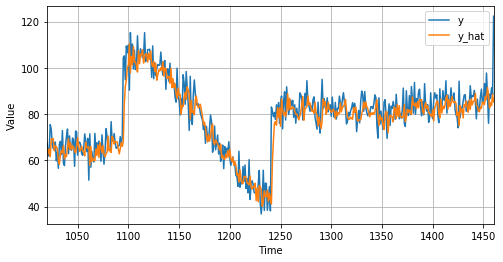

In [7]:
from util import validate

dataset_val = Dataset.from_tensor_slices(y_val) \
    .window(WINDOW_SIZE, shift=1, drop_remainder=True) \
    .flat_map(lambda window: window.batch(WINDOW_SIZE)) \
    .batch(32).prefetch(1)

forecast = model.predict(dataset_val)
df_forecast = df_val[WINDOW_SIZE:].copy()
df_forecast['y_hat'] = forecast[:-1]
validate(df_forecast)